# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns; sns.set()

from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

# Определение функций и классов

## Определение функции генерации данных

In [2]:
def make_binary_clf(N, method='line', noises=0.15, random_state=42):
    if random_state: rng = np.random.RandomState(seed = random_state)
    
    if method == 'line' or method is None:
        X, y = make_classification(n_samples=N, n_features=2,
                                   n_redundant=0, n_informative=2,
                                   n_clusters_per_class=1, class_sep=2,
                                   random_state=random_state)
        X += np.random.randn(*X.shape) * noises
        out = (X, y)
    
    elif method == 'moons':
        X, y = make_moons(n_samples=N, noise=noises, 
                          random_state=random_state)
    
    elif method == 'circles':    
        X, y = make_circles(n_samples=N, noise=noises, factor=0.5,
                            random_state=random_state )

    return X, y

#---------------------------------
def plot_data(ax, ds,name='', marker='o', colors=("#FF0000", '#0000FF'), alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)

    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker=marker, c=y,
                   cmap=cm_bright,s=s,
                   alpha=alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker=marker, c=y,
                   cmap=cm_bright,s=s,
                   facecolor='None',
                   alpha=alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

## Определение класса линейной регрессии

In [3]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self, yhat, y):
        return np.square(yhat - y).sum() / y.size
    
    #---------------------------------
    def grad_step(self, yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size) / np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1 - np.sum(np.square(y - yhat)) / np.sum(np.square(y - np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias, self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size // self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X, y)): 
                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]

    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0, y.size, self.batch_size):
            idx_batch = idxs[i_batch:i_batch + self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize=(12, 6), title=''):
        plt.figure(figsize=figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize=24)
        plt.ylabel('Функция Потерь', fontsize=24)
        plt.title(title, fontsize=24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

## Определение класса эластичной регуляризации

In [4]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty  + l2_term)

## Определение класса логистической регрессии

In [5]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty    = 0.0,
                 l2_penalty    = 0.0,
                 epochs        = 100, 
                 weights       = None, 
                 bias          = None, 
                 threshold     = 0.5,
                 batch_size    = 1000, 
                 n_batches     = None,
                 random_state  = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold

    #---------------------------------    
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term   
    #---------------------------------
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    #---------------------------------
    def forward(self, X):     
        return self.sigmoid(np.dot(X, self.weights))

    #---------------------------------
    def to_class(self,logit):
        return (logit>=self.threshold)*1

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return self.to_class(yhat)

    #---------------------------------
    def predict_prob(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat 

    #---------------------------------
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size

    #---------------------------------
    def plot_desicion_function(self, X, y, figsize=(12,6),
                               marker='o', colors=("#FF0000", '#0000FF'),
                               alpha=0.7, s=150, poly=False, order=2):
        plt.figure(figsize = figsize)
        cm_bright = ListedColormap(colors)
        plt.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha);
        h =  (X[:, 0].max() - X[:, 0].min())/50
        x_min, x_max = X[:, 0].min()-0.5 , X[:, 0].max()+0.5
        y_min, y_max = X[:, 1].min()-0.5 , X[:, 1].max()+0.5    
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        if poly:
            Z = self.predict_prob(to_polynom(np.c_[xx.ravel(), yy.ravel()],order))-0.5
        else:
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()])-0.5
        cm = plt.cm.RdBu
        Z = Z.reshape(xx.shape) 
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()

    #---------------------------------
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        n= sum(yhat==0)
        p = sum(yhat==1)
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.4f'%(tp/p), end = '\t')
        print('True Negatives:%.4f'%(tn/n))
        print('False Positives:%.4f'%(fp/p), end = '\t')
        print('False Negatives:%.4f'%(fn/n))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

## Описания функции создания полинома из входных данных

In [6]:
def to_polynom(X, order=2):
    order_range = range(order, order+1, 1)
    out = np.copy(X)

    for i in order_range:
        out = np.hstack([out, np.power(X,i)])
    return out

## Определение функции визуализации весов

In [7]:
def weights_vis(B, B0, features_names):
    numbers = np.arange(0,len(features_names)+1)
    Bs = np.hstack([B0,B])
    tick_labels = ['B'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(Bs):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = Bs, color = cc)
    plt.xticks(np.arange(0,len(features_names)+1),np.hstack(['b0', features_names]),rotation = 45 );

# Синтетические данные

## Генерация данных

In [8]:
X_moon, y_moon = make_binary_clf(300, method='moons', noises=0.3)
X_circle, y_circle = make_binary_clf(300, method='circles', noises=0.5)

##  Визуализация данных

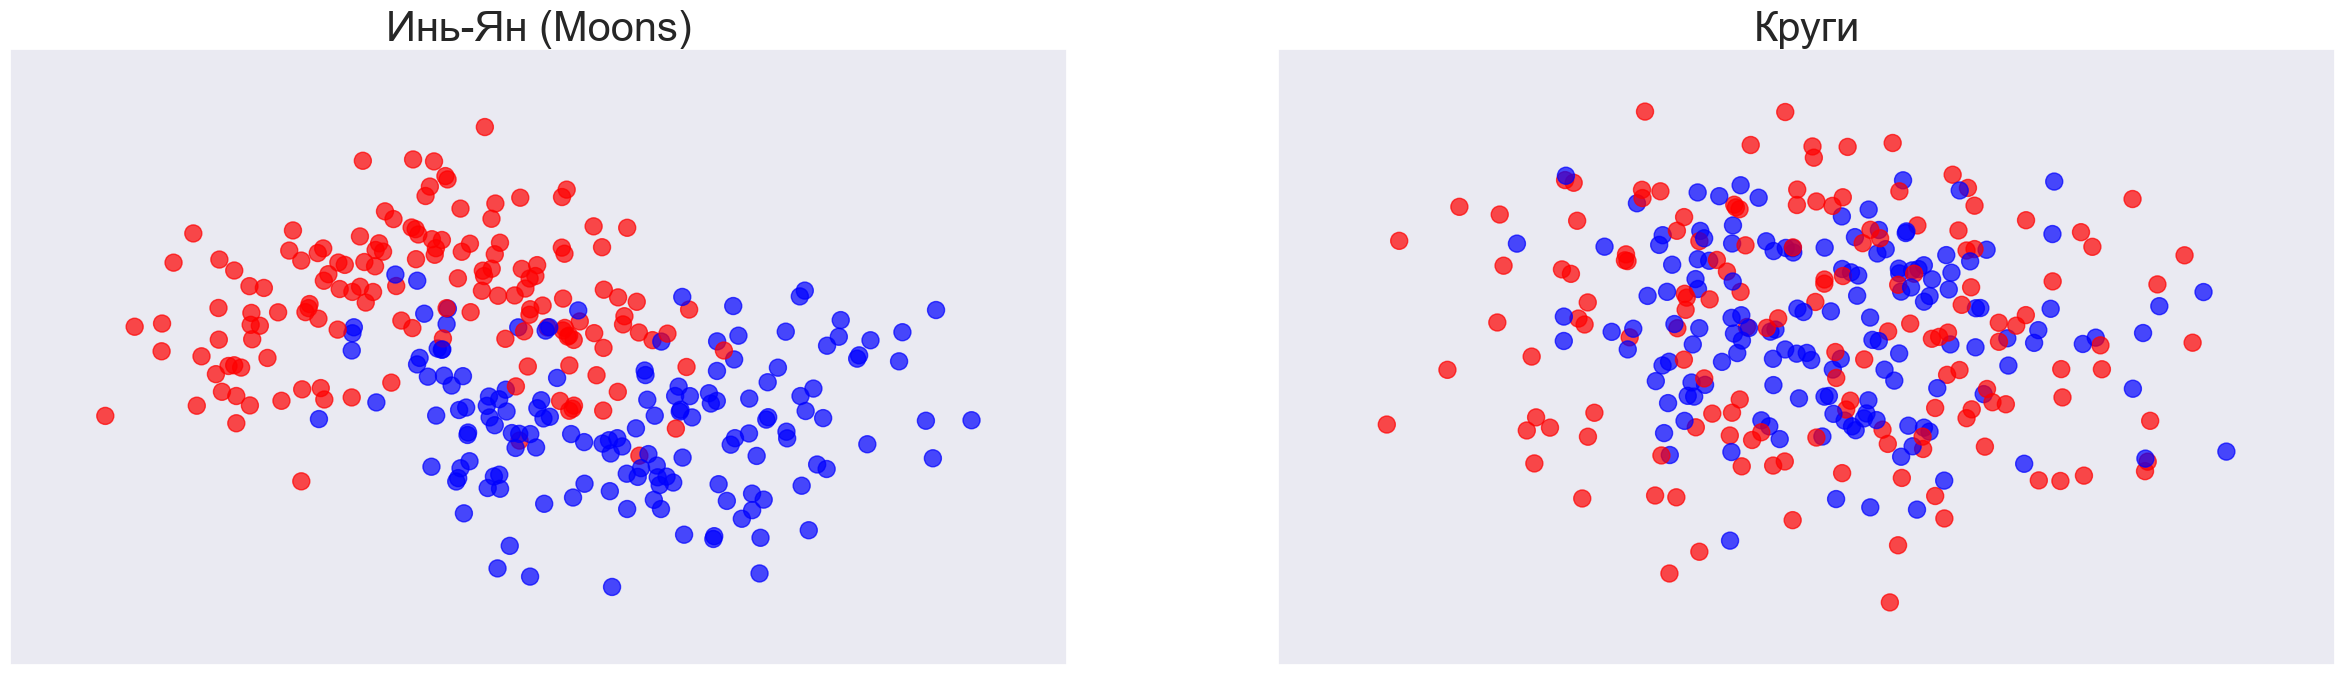

In [9]:
fig=plt.figure(figsize=(30, 8))

ax = plt.subplot(1, 2, 1)
plot_data(ax, (X_moon, y_moon), 'Инь-Ян (Moons)')

ax = plt.subplot(1, 2, 2)
plot_data(ax, (X_circle, y_circle), 'Круги')

## Логистическая регрессия (Moons)

In [10]:
X_moon_train, X_moon_test, y_moon_train, y_moon_test = train_test_split(X_moon, y_moon, test_size=0.3, random_state=42)

In [11]:
logistic_regression = LogisticRegression(
    learning_rate=0.25,
    epochs=500,
    batch_size=50
)

logistic_regression.fit(X_moon_train, y_moon_train)
logistic_regression.classification_report(X_moon_test, y_moon_test)

True Positives:0.9000	True Negatives:0.8250
False Positives:0.1000	False Negatives:0.1750
Accuracy:0.8667
Recall:0.8654	Precision:0.9000
f1 measure:0.8824


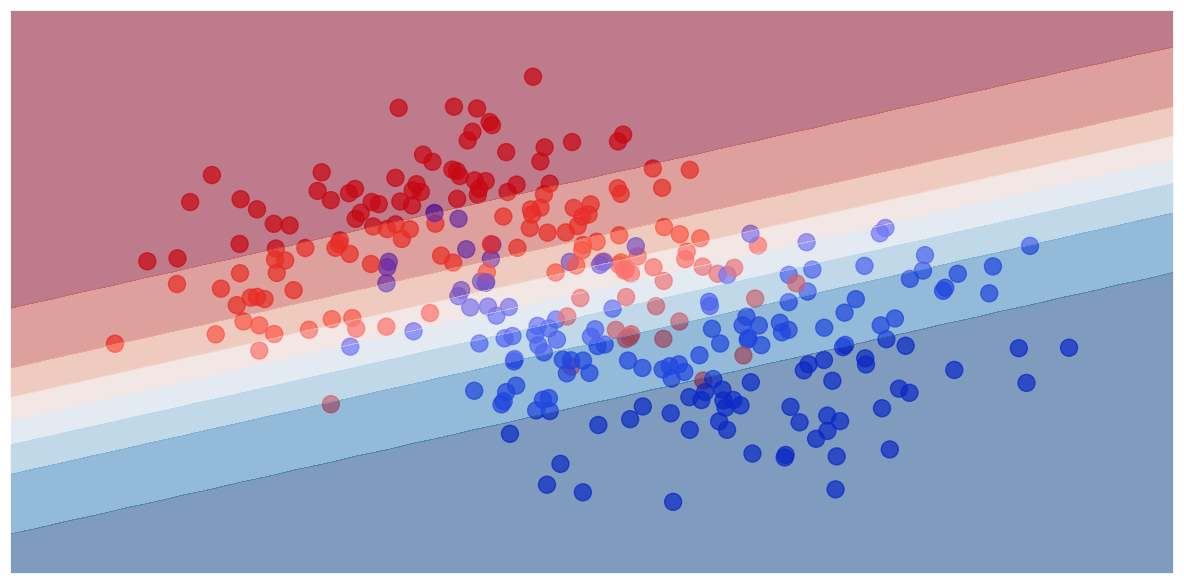

In [12]:
logistic_regression.plot_desicion_function(X_moon, y_moon)

### Полиномиальная логистическая регрессия

In [13]:
X_moon_poly = to_polynom(X_moon, order=4)

X_moon_poly_train, X_moon_poly_test, y_moon_poly_train, y_moon_poly_test = train_test_split(X_moon_poly, y_moon, test_size=0.3, random_state=42)

In [14]:
logistic_regression = LogisticRegression(
    learning_rate=0.25,
    epochs=500,
    batch_size=50
)

logistic_regression.fit(X_moon_poly_train, y_moon_poly_train)
logistic_regression.classification_report(X_moon_poly_test, y_moon_poly_test)

True Positives:0.9020	True Negatives:0.8462
False Positives:0.0980	False Negatives:0.1538
Accuracy:0.8778
Recall:0.8846	Precision:0.9020
f1 measure:0.8932


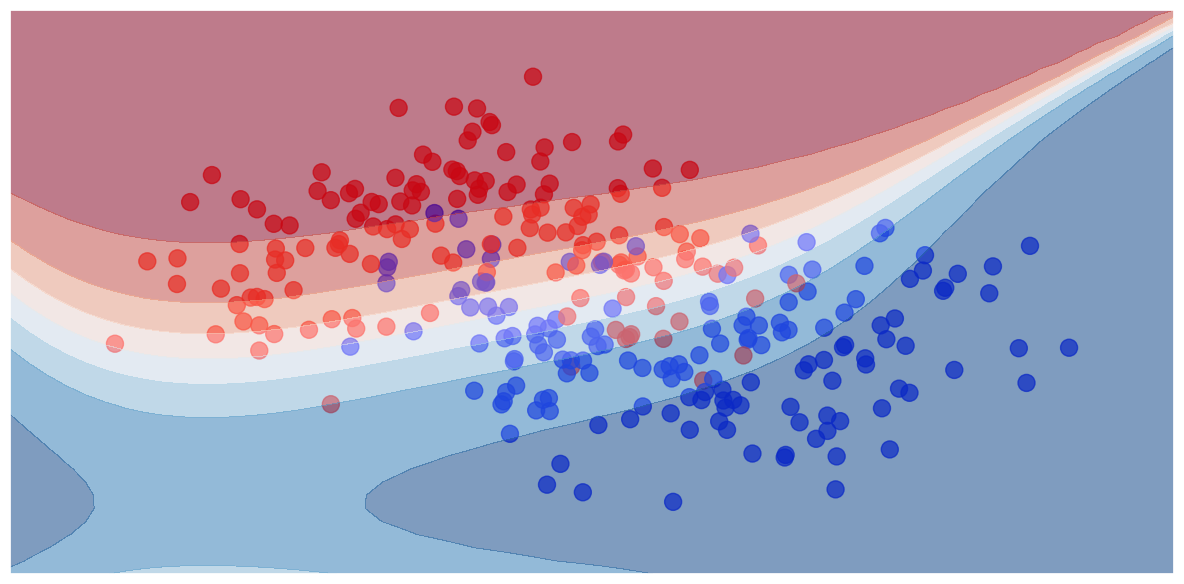

In [15]:
logistic_regression.plot_desicion_function(X_moon_poly, y_moon, poly=True, order=4)

### L1 регуляризация

In [16]:
logistic_regression = LogisticRegression(
    learning_rate=0.25,
    epochs=500,
    batch_size=50,
    l1_penalty = 0.05
)

logistic_regression.fit(X_moon_train, y_moon_train)
logistic_regression.classification_report(X_moon_test, y_moon_test)

True Positives:0.9020	True Negatives:0.8462
False Positives:0.0980	False Negatives:0.1538
Accuracy:0.8778
Recall:0.8846	Precision:0.9020
f1 measure:0.8932


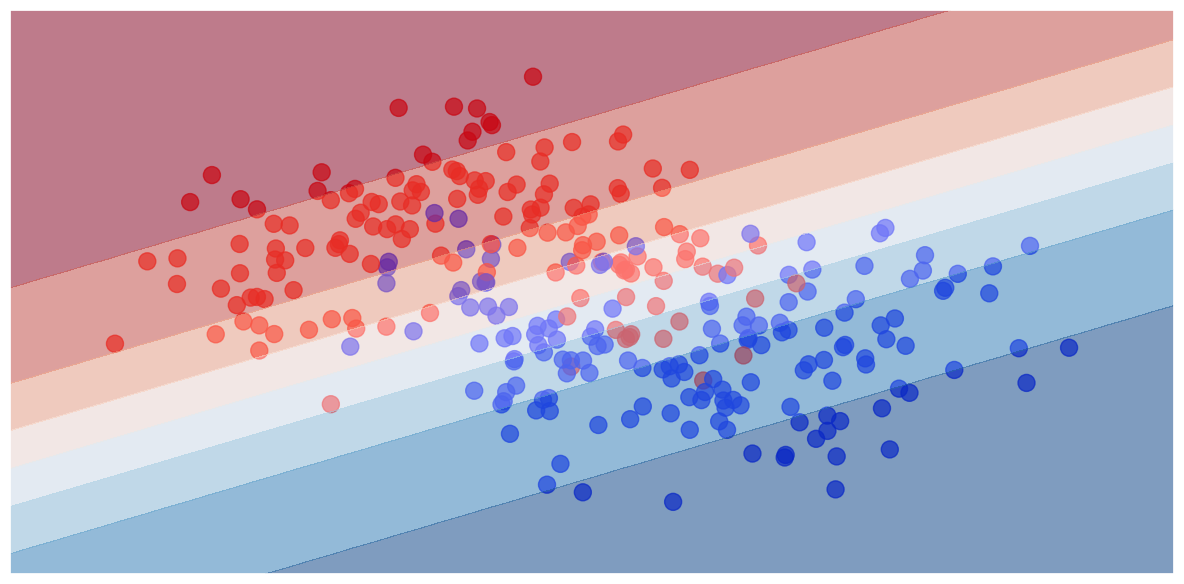

In [17]:
logistic_regression.plot_desicion_function(X_moon, y_moon)

### L2 регуляризация

In [18]:
logistic_regression = LogisticRegression(
    learning_rate=0.25,
    epochs=500,
    batch_size=50,
    l2_penalty = 0.00005
)

logistic_regression.fit(X_moon_train, y_moon_train)
logistic_regression.classification_report(X_moon_test, y_moon_test)

True Positives:0.9020	True Negatives:0.8462
False Positives:0.0980	False Negatives:0.1538
Accuracy:0.8778
Recall:0.8846	Precision:0.9020
f1 measure:0.8932


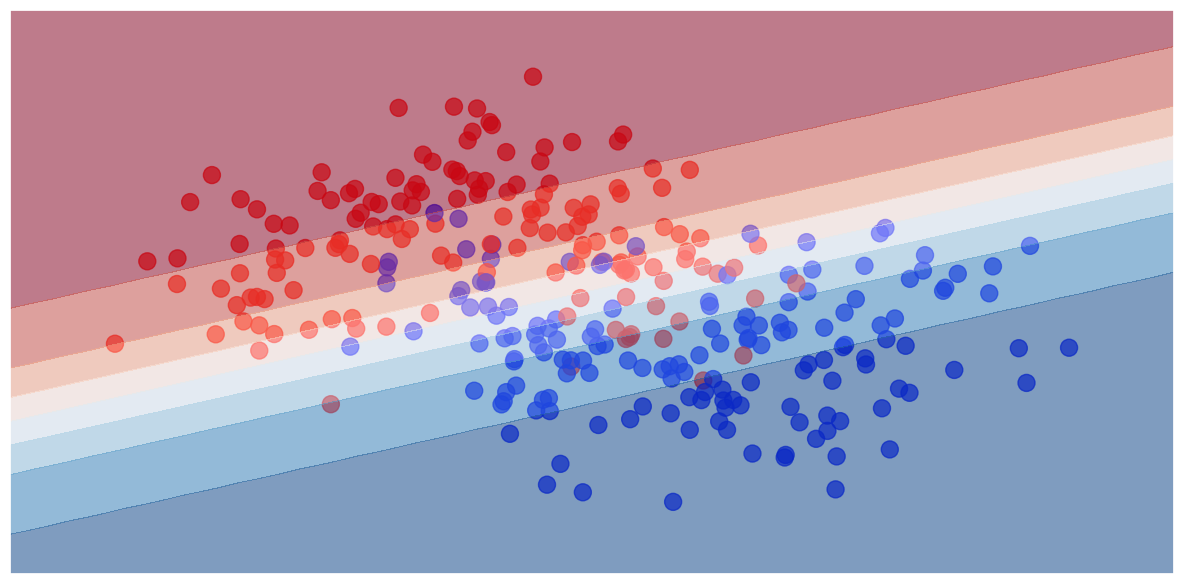

In [19]:
logistic_regression.plot_desicion_function(X_moon, y_moon)

## Логистическая регрессия (Circles)

In [20]:
X_circle_train, X_circle_test, y_circle_train, y_circle_test = train_test_split(X_circle, y_circle, test_size=0.3, random_state=42)

In [21]:
logistic_regression = LogisticRegression(
    learning_rate=0.25,
    epochs=500,
    batch_size=50
)

logistic_regression.fit(X_circle_train, y_circle_train)
logistic_regression.classification_report(X_circle_test, y_circle_test)

True Positives:0.5000	True Negatives:0.4167
False Positives:0.5000	False Negatives:0.5833
Accuracy:0.4222
Recall:0.0577	Precision:0.5000
f1 measure:0.1034


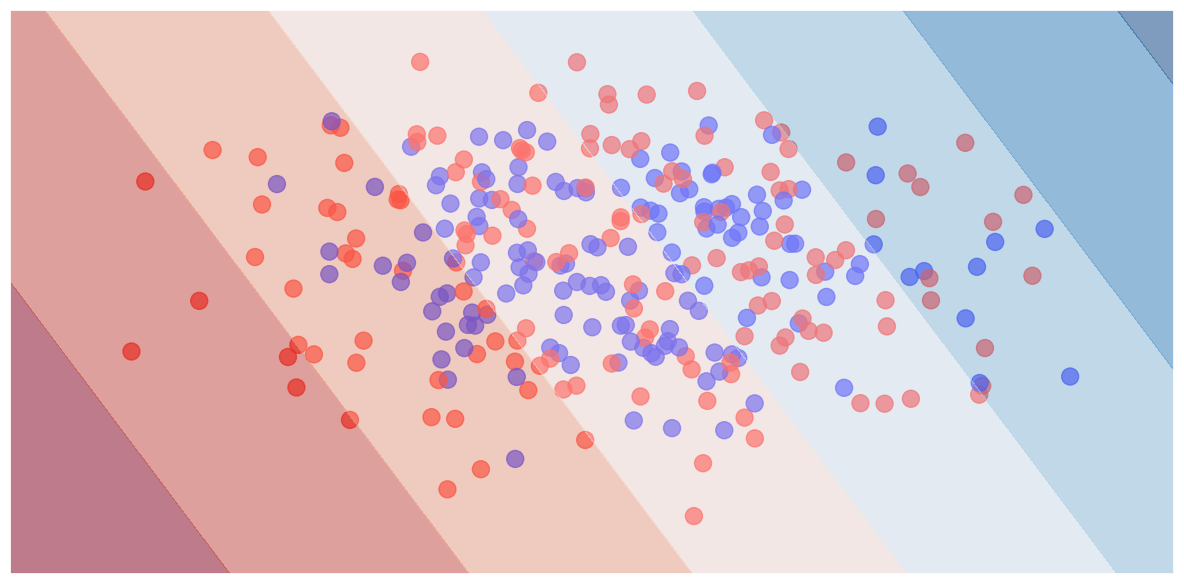

In [22]:
logistic_regression.plot_desicion_function(X_circle, y_circle)

### Полиномиальная логистическая регрессия

In [23]:
X_circle_poly = to_polynom(X_circle, order=4)

X_circle_poly_train, X_circle_poly_test, y_circle_poly_train, y_circle_poly_test = train_test_split(X_circle_poly, y_circle, test_size=0.3, random_state=42)

In [24]:
logistic_regression = LogisticRegression(
    learning_rate=0.25,
    epochs=500,
    batch_size=50,
    l1_penalty = 0.005
)

logistic_regression.fit(X_circle_poly_train, y_circle_poly_train)
logistic_regression.classification_report(X_circle_poly_test, y_circle_poly_test)

True Positives:0.6786	True Negatives:0.4677
False Positives:0.3214	False Negatives:0.5323
Accuracy:0.5333
Recall:0.3654	Precision:0.6786
f1 measure:0.4750


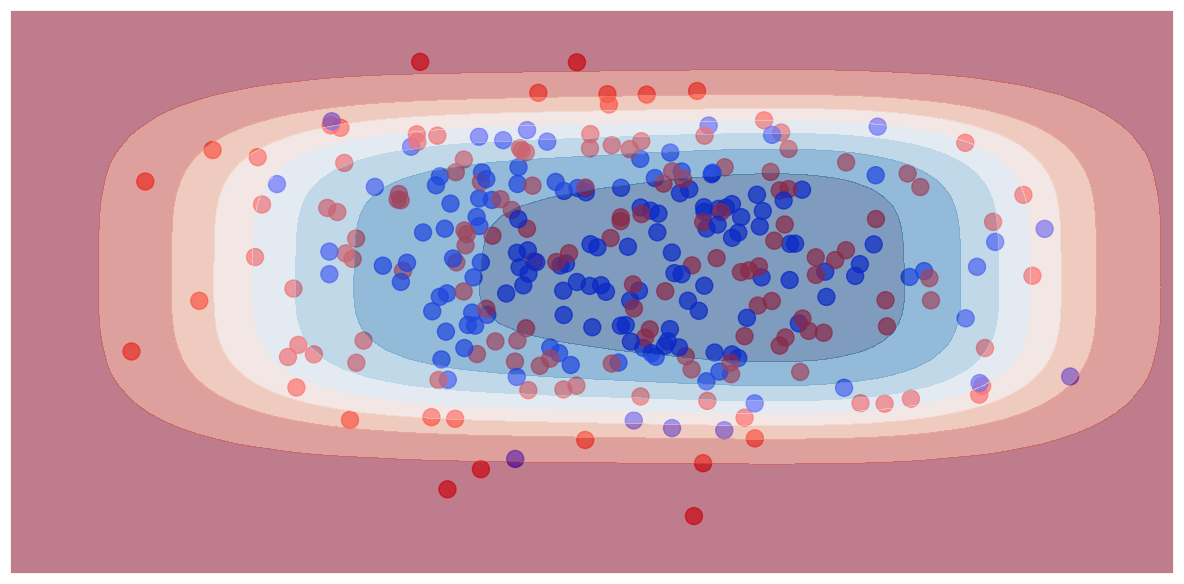

In [25]:
logistic_regression.plot_desicion_function(X_circle_poly, y_circle, poly=True, order=4)

### L1 регуляризация

In [26]:
logistic_regression = LogisticRegression(
    learning_rate=0.25,
    epochs=500,
    batch_size=50,
    l1_penalty = 0.007
)

logistic_regression.fit(X_circle_train, y_circle_train)
logistic_regression.classification_report(X_circle_test, y_circle_test)

True Positives:0.5000	True Negatives:0.4167
False Positives:0.5000	False Negatives:0.5833
Accuracy:0.4222
Recall:0.0577	Precision:0.5000
f1 measure:0.1034


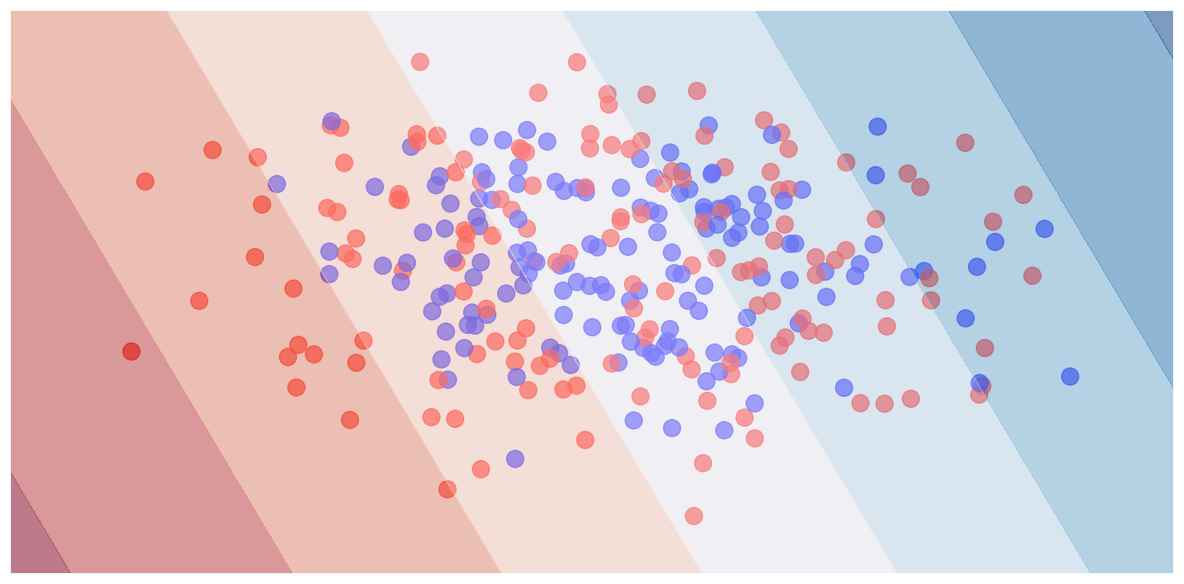

In [27]:
logistic_regression.plot_desicion_function(X_circle, y_circle)

### L2 регуляризация

In [28]:
logistic_regression = LogisticRegression(
    learning_rate=0.1,
    epochs=500,
    batch_size=50,
    l2_penalty = 0.06
)

logistic_regression.fit(X_circle_train, y_circle_train)
logistic_regression.classification_report(X_circle_test, y_circle_test)

True Positives:0.5000	True Negatives:0.4186
False Positives:0.5000	False Negatives:0.5814
Accuracy:0.4222
Recall:0.0385	Precision:0.5000
f1 measure:0.0714


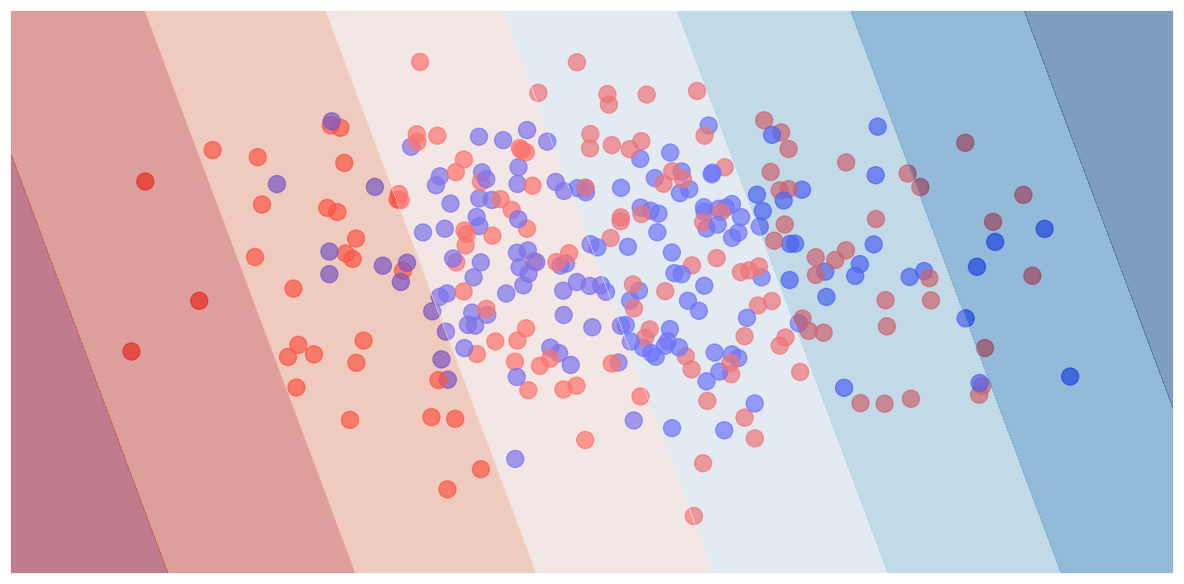

In [29]:
logistic_regression.plot_desicion_function(X_circle, y_circle)

# Набора данных Cars Moldova

## Импорт библиотек

In [30]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1

## Загрузка данных

In [31]:
car_df = pd.read_csv('data/cars_moldova_data.csv', delimiter=',')

In [32]:
car_df.sample(5)

,Make,Model,Year,Style,Distance,Engine_capacity,Fuel_type,Transmission,Price,Age,Km_year,Km_year_quantile,Make_model,Make_model_mean_price,Make_model_median_price
8250,Lexus,Es Series,2013,Sedan,101546.0,2013.0,Hybrid,Automatic,18200.0,9,11282.888889,Небольшой пробег,Lexus Es Series,16837.303371,16900.0
9420,Volkswagen,Passat,1998,Universal,352225.0,1900.0,Diesel,Manual,1150.0,24,14676.041667,Средний пробег,Volkswagen Passat,6767.408497,5700.0
2084,Volkswagen,Golf,2015,Hatchback,145000.0,2000.0,Petrol,Automatic,12999.0,7,20714.285714,Большой пробег,Volkswagen Golf,5799.978208,4999.0
7783,Toyota,Prius +,2014,Universal,235573.0,1800.0,Metan/Propan,Automatic,11999.0,8,29446.625000,Большой пробег,Toyota Prius +,9943.121212,9990.0
35148,Opel,Astra,2006,Universal,220000.0,1248.0,Diesel,Manual,3900.0,16,13750.000000,Средний пробег,Opel Astra,4488.550877,4300.0


## Работа с данными

### Выделим числовые и категориальные столбцы

In [33]:
def split_column_by_types(df):
    category_columns = []
    number_columns = []

    for column in df.columns:
        if df[column].dtypes == object or df[column].dtypes == 'category':
            category_columns += [column]
        else:
            number_columns += [column]
    
    return category_columns, number_columns

In [34]:
category_columns, number_columns = split_column_by_types(car_df)

print(category_columns)
print(number_columns)

['Make', 'Model', 'Style', 'Fuel_type', 'Transmission', 'Km_year_quantile', 'Make_model']
['Year', 'Distance', 'Engine_capacity', 'Price', 'Age', 'Km_year', 'Make_model_mean_price', 'Make_model_median_price']


## Логистическая регрессия (числовые признаки)

### Создадим набор данных только с числовыми признаками

In [35]:
car_df_number = car_df[number_columns].copy()
car_df_number.head(5)

,Year,Distance,Engine_capacity,Price,Age,Km_year,Make_model_mean_price,Make_model_median_price
0,2011,195000.0,1800.0,7750.0,11,17727.272727,8276.508621,7900.0
1,2014,135000.0,1500.0,8550.0,8,16875.000000,7177.654912,6999.0
2,2012,110000.0,1500.0,6550.0,10,11000.000000,4598.121951,5099.0
3,2006,200000.0,1600.0,4100.0,16,12500.000000,4488.550877,4300.0
4,2000,300000.0,2200.0,3490.0,22,13636.363636,8236.543333,7500.0


### Нормализация данных

In [36]:
car_df_number_norm = car_df_number.copy()

x_min = car_df_number_norm[number_columns].min()
x_max = car_df_number_norm[number_columns].max()

car_df_number_norm[number_columns] = (car_df_number_norm[number_columns] - x_min) / (x_max - x_min)

### Стандартизация данных

In [37]:
car_df_number_scale = car_df_number.copy()

x_mean = car_df_number_scale[number_columns].mean()
x_std = car_df_number_scale[number_columns].std()

car_df_number_scale[number_columns] = (car_df_number_scale[number_columns] - x_mean) / x_std

### Логарифмирование и стандартизация данных

In [38]:
car_df_number_log = car_df_number.copy()

car_df_number_log[number_columns] = np.log(car_df_number_log[number_columns])

x_mean = car_df_number_log[number_columns].mean()
x_std = car_df_number_log[number_columns].std()

car_df_number_log[number_columns] = (car_df_number_log[number_columns] - x_mean) / x_std

In [39]:
car_df['Transmission'] = car_df['Transmission'].astype('category')

X_norm, y_norm_true = car_df_number_norm.values, car_df['Transmission'].cat.codes.values
X_scale, y_scale_true = car_df_number_scale.values, car_df['Transmission'].cat.codes.values
X_log, y_log_true = car_df_number_log.values, car_df['Transmission'].cat.codes.values

### Логистическая регрессия (нормализованные данные)

In [40]:
logistic_regression = LogisticRegression(
    fit_intercept=True,
    penalty='l1',
    solver='saga',
    C=3,
    max_iter=100000
)

X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(
    X_norm,
    y_norm_true,
    test_size=0.3,
    random_state=42
)

logistic_regression.fit(X_norm_train, y_norm_train);

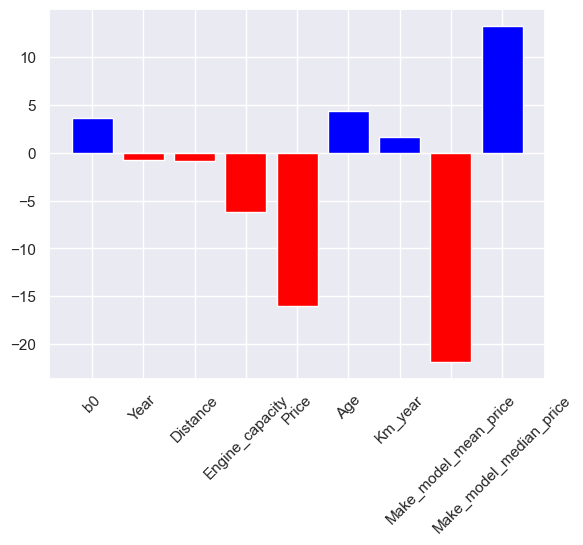

In [41]:
weights_vis(logistic_regression.coef_[0], logistic_regression.intercept_[0], car_df_number_norm[number_columns].columns)

In [42]:
scoring = {'ACC': 'accuracy', 'F1': 'f1', 'Precision': 'precision', 'Recall': 'recall'}
           
scores = cross_validate(
    logistic_regression,
    X_norm_train,
    y_norm_train,
    scoring=scoring,
    cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
)

display(pd.DataFrame(scores))

,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,0.263026,0.006974,0.814398,0.832517,0.802940,0.864356
1,0.241998,0.006000,0.815768,0.834717,0.800623,0.871843
2,0.240998,0.006002,0.818785,0.835193,0.811301,0.860535
3,0.230998,0.005001,0.815165,0.832391,0.806360,0.860158
4,0.231000,0.006001,0.819992,0.838593,0.803942,0.876366


In [43]:
print(pd.DataFrame(scores).mean()[2:])

test_ACC          0.816822
test_F1           0.834682
test_Precision    0.805033
test_Recall       0.866652
dtype: float64


### Логистическая регрессия (стандартизированные данные)

In [44]:
logistic_regression = LogisticRegression(
    fit_intercept=True,
    penalty='l1',
    solver='saga',
    C=3,
    max_iter=100000
)

X_scale_train, X_scale_test, y_scale_train, y_scale_test = train_test_split(
    X_scale,
    y_scale_true,
    test_size=0.3,
    random_state=42
)

logistic_regression.fit(X_scale_train, y_scale_train);

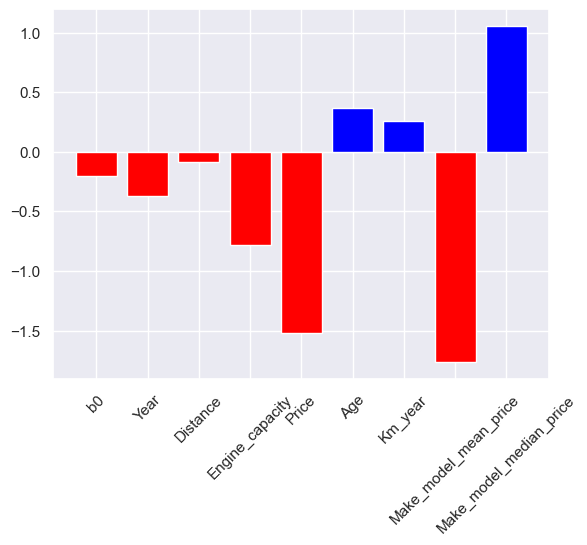

In [45]:
weights_vis(logistic_regression.coef_[0], logistic_regression.intercept_[0], car_df_number_scale[number_columns].columns)

In [46]:
scoring = {'ACC': 'accuracy', 'F1': 'f1', 'Precision': 'precision', 'Recall': 'recall'}
           
scores = cross_validate(
    logistic_regression,
    X_scale_train,
    y_scale_train,
    scoring=scoring,
    cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
)

display(pd.DataFrame(scores))

,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,0.110028,0.005970,0.814197,0.832366,0.802659,0.864356
1,0.113000,0.006002,0.814763,0.833724,0.800069,0.870335
2,0.110998,0.005000,0.818785,0.835072,0.811744,0.859781
3,0.106000,0.006001,0.815768,0.832969,0.806782,0.860912
4,0.110000,0.007000,0.819791,0.838326,0.804084,0.875613


In [47]:
print(pd.DataFrame(scores).mean()[2:])

test_ACC          0.816661
test_F1           0.834491
test_Precision    0.805068
test_Recall       0.866199
dtype: float64


### Логистическая регрессия (логарифмирование и стандартизация данных)

In [48]:
logistic_regression = LogisticRegression(
    fit_intercept=True,
    penalty='l1',
    solver='saga',
    C=3,
    max_iter=100000
)

X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(
    X_log,
    y_log_true,
    test_size=0.3,
    random_state=42
)

logistic_regression.fit(X_log_train, y_log_train);

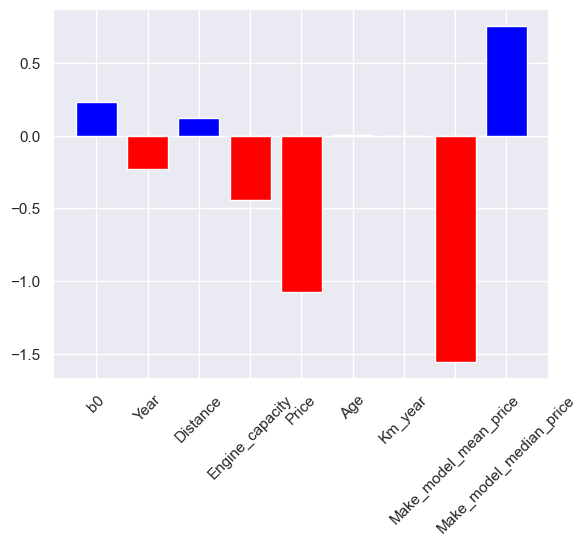

In [49]:
weights_vis(logistic_regression.coef_[0], logistic_regression.intercept_[0], car_df_number_log[number_columns].columns)

In [50]:
scoring = {'ACC': 'accuracy', 'F1': 'f1', 'Precision': 'precision', 'Recall': 'recall'}
           
scores = cross_validate(
    logistic_regression,
    X_log_train,
    y_log_train,
    scoring=scoring,
    cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
)

display(pd.DataFrame(scores))

,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,0.147998,0.006002,0.802132,0.817032,0.806535,0.827807
1,0.149999,0.006002,0.796862,0.813309,0.797969,0.829250
2,0.053998,0.006001,0.810539,0.822799,0.821254,0.824350
3,0.136998,0.006002,0.800080,0.814898,0.805300,0.824727
4,0.147000,0.006001,0.804304,0.820048,0.805011,0.835658


In [51]:
print(pd.DataFrame(scores).mean()[2:])

test_ACC          0.802784
test_F1           0.817617
test_Precision    0.807214
test_Recall       0.828358
dtype: float64


## Логистическая регрессия (числовые и категориальные признаки)

In [52]:
car_df_all = car_df.copy()
car_df_all.head(5)

,Make,Model,Year,Style,Distance,Engine_capacity,Fuel_type,Transmission,Price,Age,Km_year,Km_year_quantile,Make_model,Make_model_mean_price,Make_model_median_price
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727,Большой пробег,Toyota Prius,8276.508621,7900.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000,Средний пробег,Renault Grand Scenic,7177.654912,6999.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000,Небольшой пробег,Renault Laguna,4598.121951,5099.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000,Средний пробег,Opel Astra,4488.550877,4300.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636,Средний пробег,Mercedes Vito,8236.543333,7500.0


### Логарифмирование и стандартизация данных

In [53]:
car_df_all[number_columns] = np.log(car_df_all[number_columns])

x_mean = car_df_all[number_columns].mean()
x_std = car_df_all[number_columns].std()

car_df_all[number_columns] = (car_df_all[number_columns] - x_mean) / x_std

### Унитарное кодирование

In [54]:
car_df_transmission = pd.DataFrame(car_df_all['Transmission'])

car_df_all = car_df_all.drop(columns=['Transmission'])
car_df_all = pd.get_dummies(car_df_all)

X_all, y_all_true = car_df_all.values, car_df_transmission['Transmission'].cat.codes.values

In [55]:
logistic_regression = LogisticRegression(
    fit_intercept=True,
    solver='saga',
    penalty='l2',
    C=3,
    max_iter=10000
)

X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(
    X_all,
    y_all_true,
    test_size=0.3,
    random_state=42
)

logistic_regression.fit(X_all_train, y_all_train);

In [56]:
scoring = {'ACC': 'accuracy', 'F1': 'f1', 'Precision': 'precision', 'Recall': 'recall'}
           
scores = cross_validate(
    logistic_regression,
    X_all_train,
    y_all_train,
    scoring=scoring,
    cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
)

display(pd.DataFrame(scores))

,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,115.147026,0.012971,0.851800,0.864298,0.845157,0.884326
1,128.050025,0.015975,0.850764,0.864747,0.837275,0.894082
2,123.130026,0.011971,0.854787,0.866048,0.852758,0.879759
3,147.698275,0.016001,0.853982,0.865655,0.850236,0.881643
4,133.345646,0.013000,0.847747,0.861836,0.835456,0.889936


In [57]:
print(pd.DataFrame(scores).mean()[2:])

test_ACC          0.851816
test_F1           0.864517
test_Precision    0.844177
test_Recall       0.885949
dtype: float64


### Наибольший вес имеют признаки, связанные с ценой: `Make_model_mean_price` (средняя цена автомобиля данной модели и марки) и `Price` (цена автомобиля).